In [87]:
import os
import sys

In [88]:
def is_colab():
    try:
        import google.colab
        return True
    except ImportError:
        return False

In [89]:
if is_colab():
    from google.colab import drive
    drive.mount('/content/drive')
    
    # code required by Colab
    %cd /content/drive/MyDrive/PatMatBaselineAlena
    
    root_dir = '/content/drive/MyDrive/PatMatBaselineAlena'
else:
    current_dir = os.getcwd()
    if current_dir.endswith("notebooks"):
        root_dir = '..'
        %cd ..
    else:
        root_dir = '.'

In [90]:
current_dir = os.getcwd()
print(current_dir)

c:\Users\alena\MyFolder\DIL\PatentMatchBaselineAlena


In [91]:
# parent_dir = os.path.abspath(os.path.join(os.getcwd(), root_dir))
sys.path.append(current_dir)

In [92]:
# install requirements
!pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu121


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [93]:
import json
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader, TensorDataset
from transformers import AdamW
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score, matthews_corrcoef, roc_auc_score, average_precision_score, log_loss
import numpy as np
import numpy as np
from datetime import datetime
import mlflow

In [94]:
# # this code uploads the credentials to MLflow given in the .env file
from src.settings import (
    MLFLOW_TRACKING_URI,
    MLFLOW_TRACKING_USERNAME,
    MLFLOW_TRACKING_PASSWORD
)

In [95]:
print(MLFLOW_TRACKING_USERNAME)

Alena


In [96]:
# Check if GPU is available and set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [97]:
device

device(type='cpu')

In [98]:
# Load the tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [99]:
# Load the pre-trained BERT model for sequence classification
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [100]:
# Move the model to the proper device
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [101]:
def load_jsonl(filename):
    data = []
    with open(filename, 'r') as f:
        for line in f:
            data.append(json.loads(line))
    return data

train_data = load_jsonl('data/train_v2.jsonl')
validation_data = load_jsonl('data/test_v2.jsonl')

# Prepare the texts and labels
train_texts = [(item['text'], item['text_b']) for item in train_data]
train_labels = [item['label'] for item in train_data]
validation_texts = [(item['text'], item['text_b']) for item in validation_data]
validation_labels = [item['label'] for item in validation_data]

In [102]:
len(train_texts), len(train_labels), len(validation_texts), len(validation_labels)

(2920, 2920, 730, 730)

In [74]:
# If you don't have a GPU, limit the amount of data
if device.type == 'cpu':
    train_texts = train_texts[:10]
    train_labels = train_labels[:10]
    validation_texts = validation_texts[:10]
    validation_labels = validation_labels[:10]

The length at which 95% of the texts fit is: 323.0499999999997


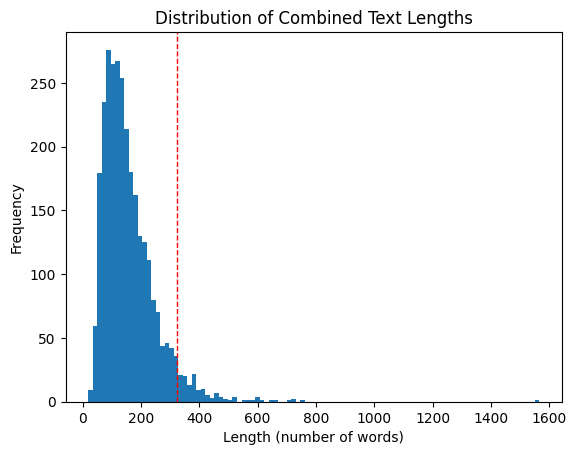

In [119]:
doc_lengths = [len((item[0] + " " + item[1]).split()) for item in train_texts]

sorted_lengths = np.sort(doc_lengths)

percentile_95_length = np.percentile(sorted_lengths, 95)
print(f"The length at which 95% of the texts fit is: {percentile_95_length}")

# Visualize the distribution of the lengths of the combined texts
plt.hist(doc_lengths, bins=100)
plt.axvline(percentile_95_length, color='r', linestyle='dashed', linewidth=1)
plt.title('Distribution of Combined Text Lengths')
plt.xlabel('Length (number of words)')
plt.ylabel('Frequency')
plt.show()

In [123]:
num_texts_below_given_length = np.sum(sorted_lengths <= 384)

# Calculate the percentage
percentage_texts_below_given_length = (num_texts_below_given_length / len(sorted_lengths)) * 100

print(f"The percentage of combined texts below 384 words (roughly 512 tokens) is: {percentage_texts_below_given_length:.2f}%")

The percentage of combined texts below 384 words (roughly 512 tokens) is: 97.77%


In [75]:
config = {
    'learning_rate': 2e-5,
    'batch_size': 32,
    'num_epochs': 7,
    'max_length': 512,
    'test_size': 0.2,
    'random_state': 42,
}

In [77]:
train_encodings = tokenizer(train_texts, padding=True, truncation=True, return_tensors="pt", max_length=config['max_length'])
validation_encodings = tokenizer(validation_texts, padding=True, truncation=True, return_tensors="pt", max_length=config['max_length'])

train_input_ids = train_encodings['input_ids']
train_attention_mask = train_encodings['attention_mask']
validation_input_ids = validation_encodings['input_ids']
validation_attention_mask = validation_encodings['attention_mask']

# Convert labels to tensors
train_labels = torch.tensor(train_labels, dtype=torch.long)
validation_labels = torch.tensor(validation_labels, dtype=torch.long)

In [80]:
decoded = tokenizer.decode(train_encodings["input_ids"][3])
print(decoded)

[CLS] the method of claim 11 wherein the at least one heat source 30 extends from the at least one turbine component support platform 20. [SEP] the impingement hole patterns in the two baffles are preferably configured to distribute more of the available coolant 12 in each of the vanes to the inboard sidewalls 28 34 then to the corresponding outboard sidewalls 30 32. in this way the impingement baffles cooperate with the sidewall outlets 44 46 48 described above to collectively effect the desired different cooling configurations of the two vanes for preferentially cooling the inboard sidewalls thereof for the benefits previously disclosed. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD

In [21]:
train_input_ids.shape, train_attention_mask.shape, validation_input_ids.shape, validation_attention_mask.shape

(torch.Size([10, 271]),
 torch.Size([10, 271]),
 torch.Size([10, 268]),
 torch.Size([10, 268]))

In [22]:
train_labels.shape, validation_labels.shape

(torch.Size([10]), torch.Size([10]))

In [23]:
train_data = TensorDataset(train_input_ids, train_attention_mask, train_labels)
validation_data = TensorDataset(validation_input_ids, validation_attention_mask, validation_labels)

In [24]:
train_data.tensors[0].shape, train_data.tensors[1].shape, train_data.tensors[2].shape

(torch.Size([10, 271]), torch.Size([10, 271]), torch.Size([10]))

In [25]:
validation_data.tensors[0].shape, validation_data.tensors[1].shape, validation_data.tensors[2].shape

(torch.Size([10, 268]), torch.Size([10, 268]), torch.Size([10]))

In [26]:
train_dataloader = DataLoader(train_data, batch_size=config["batch_size"])
validation_dataloader = DataLoader(validation_data, batch_size=config["batch_size"])


In [27]:
for batch in train_dataloader:
    print(batch[0].shape, batch[1].shape, batch[2].shape)
    break

torch.Size([10, 271]) torch.Size([10, 271]) torch.Size([10])


In [28]:
# Define the optimizer
optimizer = AdamW(model.parameters(), lr=config['learning_rate'], no_deprecation_warning=True)

In [29]:
print(MLFLOW_TRACKING_USERNAME)

Alena


In [30]:
# This variable along with the timestamp will be used to create the name of the experiment run. By default, this is the MLflow username, but you can change it as you like.
user = MLFLOW_TRACKING_USERNAME
# This variable will be the name of the folder in MLflow. You can change it as you wish.
# If you provide the name of an already existing experiment, the experiment runs will be saved in the specified folder.
# If you provide the name of a non-existent experiment, you will create a new folder with the given name.
experiment_name = 'Alena_PatentMatchBaseline'


def timestamp():
    """This function creates current timestamp"""
    return datetime.now().strftime("%Y_%m_%d_%H%M_%S")

In [31]:
# If you have provided the name of an experiment that does not exist or that existed in MLflow but was deleted, create a new experiment.
experiment = mlflow.get_experiment_by_name(experiment_name)
if experiment is None or experiment.lifecycle_stage == 'deleted':
    mlflow.create_experiment(experiment_name)
    experiment = mlflow.get_experiment_by_name(experiment_name)

In [32]:
save_model = True

In [33]:
if save_model:
    model_save_path = 'models/'

    if not os.path.exists(model_save_path):
        os.makedirs(model_save_path)

In [35]:
with mlflow.start_run(experiment_id=experiment.experiment_id):
    for param_name, param_value in config.items():
        mlflow.log_param(param_name, param_value)

    best_val_loss = float('inf')

    for epoch in range(config['num_epochs']):  # Number of training epochs
        print(f'############### Started {epoch + 1} epoch ###############')
        # Set run name
        mlflow.set_tag(key='mlflow.runName',
                       value=f'{timestamp()}_{user}')
        model.train()
        train_loss = 0.0
        for batch in train_dataloader:
            b_input_ids, b_attention_mask, b_labels = batch

            # Move the batch to the proper device
            b_input_ids = b_input_ids.to(device)
            b_attention_mask = b_attention_mask.to(device)
            b_labels = b_labels.to(device)

            model.zero_grad()
            outputs = model(b_input_ids, attention_mask=b_attention_mask, labels=b_labels)
            loss = outputs.loss
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # Log the average training loss for the epoch
        avg_train_loss = train_loss / len(train_dataloader)
        mlflow.log_metric("train_loss", avg_train_loss, step=epoch)
        print(f"Average training loss for epoch {epoch}: {avg_train_loss}")

        # Validation loop
        model.eval()
        val_loss = 0.0
        predictions, true_labels = [], []
        for batch in validation_dataloader:
            b_input_ids, b_attention_mask, b_labels = batch

            # Move the batch to the proper device
            b_input_ids = b_input_ids.to(device)
            b_labels = b_labels.to(device)
            b_attention_mask = b_attention_mask.to(device)

            with torch.no_grad():
                outputs = model(b_input_ids, attention_mask=b_attention_mask, labels=b_labels)

            logits = outputs.logits
            loss = outputs.loss
            val_loss += loss.item()

            predictions.extend(torch.argmax(logits, dim=1).cpu().tolist())
            true_labels.extend(b_labels.cpu().tolist())

        # Log the average validation loss for the epoch
        avg_val_loss = val_loss / len(validation_dataloader)
        mlflow.log_metric("val_loss", avg_val_loss, step=epoch)
        print(f"Average validation loss for epoch {epoch}: {avg_val_loss}")

        # Calculate the accuracy of the predictions
        val_accuracy = accuracy_score(true_labels, predictions)
        print(f"Validation Accuracy: {val_accuracy}")
        mlflow.log_metric("val_accuracy", val_accuracy, step=epoch)

        # Calculate additional metrics
        val_precision = precision_score(true_labels, predictions, zero_division='warn')
        val_recall = recall_score(true_labels, predictions, zero_division="warn")
        val_f1 = f1_score(true_labels, predictions, zero_division="warn")
        val_mcc = matthews_corrcoef(true_labels, predictions)

        # Log additional metrics
        mlflow.log_metric("val_precision", val_precision, step=epoch)
        mlflow.log_metric("val_recall", val_recall, step=epoch)
        mlflow.log_metric("val_f1", val_f1, step=epoch)
        mlflow.log_metric("val_mcc", val_mcc, step=epoch)

        print(f"Validation Precision: {val_precision}")
        print(f"Validation Recall: {val_recall}")
        print(f"Validation F1 Score: {val_f1}")
        print(f"Validation MCC: {val_mcc}")
        
        # Save the best model based on validation loss
        if save_model:
            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                best_model_save_file = f"{model_save_path}best_model.pt"
                torch.save(model.state_dict(), best_model_save_file)
                print(f"Best model saved to {best_model_save_file}")

        # Calculate the confusion matrix
        cm = confusion_matrix(true_labels, predictions, normalize='true')
        cm_filename = f"artifacts/{timestamp()}_confusion_matrix_epoch_{epoch}.csv"
        np.savetxt(cm_filename, cm, delimiter=",")
        mlflow.log_artifact(cm_filename)

        # Print the confusion matrix
        print(cm)
        print(f'############### Finished {epoch + 1} epoch ###############\n\n')

mlflow.end_run()

############# Started 1 epoch ###############
Average training loss for epoch 0: 0.4347972273826599
Average validation loss for epoch 0: 0.5712020993232727
Validation Accuracy: 0.8
Validation Precision: 0.875
Validation Recall: 0.875
Validation F1 Score: 0.875
Validation MCC: 0.375
Best model saved to models/best_model.pt
[[0.5   0.5  ]
 [0.125 0.875]]
############# Finished 1 epoch ###############


############# Started 2 epoch ###############
Average training loss for epoch 1: 0.38594797253608704
Average validation loss for epoch 1: 0.5955017805099487
Validation Accuracy: 0.8
Validation Precision: 1.0
Validation Recall: 0.75
Validation F1 Score: 0.8571428571428571
Validation MCC: 0.6123724356957946
[[1.   0.  ]
 [0.25 0.75]]
############# Finished 2 epoch ###############


############# Started 3 epoch ###############
Average training loss for epoch 2: 0.34419533610343933
Average validation loss for epoch 2: 0.6513045430183411
Validation Accuracy: 0.7
Validation Precision: 1.0
Valid

c:\Users\alena\MyFolder\DIL\PatentMatchBaselineAlena\venv\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Precision: 0.0
Validation Recall: 0.0
Validation F1 Score: 0.0
Validation MCC: 0.0
[[1. 0.]
 [1. 0.]]
############# Finished 6 epoch ###############


############# Started 7 epoch ###############
Average training loss for epoch 6: 0.28615766763687134
Average validation loss for epoch 6: 0.8772857785224915
Validation Accuracy: 0.2


c:\Users\alena\MyFolder\DIL\PatentMatchBaselineAlena\venv\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation Precision: 0.0
Validation Recall: 0.0
Validation F1 Score: 0.0
Validation MCC: 0.0
[[1. 0.]
 [1. 0.]]
############# Finished 7 epoch ###############


